# **Линейные модели, SVM и деревья решений.**

**Цель лабораторной работы**: изучение линейных моделей, SVM и деревьев решений.\
**Задание:**
- Выберите набор данных (датасет) для решения задачи классификации или регрессии.
- В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
- С использованием метода train_test_split разделите выборку на обучающую и тестовую.
- Обучите следующие модели:
 - одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
 - SVM;
 - дерево решений.
- Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
- Постройте график, показывающий важность признаков в дереве решений.
- Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

### **Импорт библиотек и загрузка датасета**
Импортируем библиотеки с помощью команды import.

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.model_selection import train_test_split
from operator import itemgetter
import matplotlib.ticker as ticker
import math
from enum import Enum
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from typing import Dict, Tuple
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR

In [73]:
filename = '../datasets/water_potability.csv'
data0 = pd.read_csv(filename)

In [74]:
target0 = data0['Potability']
data0_train,data,y0_train,y0_test=train_test_split(data0,target0,test_size=0.1,random_state=1)

### **Очистка датасета**

Основываясь на том, что мы делали выше, обработаем все остальные столбцы и таким образом полностью почистим набор

In [75]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,280.000000,328.000000,328.000000,328.000000,243.000000,328.000000,328.000000,314.000000,328.000000,328.000000
mean,7.000819,199.321509,22107.668041,7.215129,332.530988,428.656241,14.237119,65.942173,3.998319,0.429878
std,1.511238,34.736547,9172.940196,1.609980,43.130297,78.414858,3.453760,17.395396,0.779850,0.495815
min,3.410360,94.908977,1351.906979,1.390871,129.000000,257.963154,5.218233,8.175876,2.000757,0.000000
25%,6.018032,179.639806,15317.963236,6.281403,308.301105,367.389675,11.853190,54.381582,3.513887,0.000000
50%,6.921028,201.577259,20459.828947,7.304778,330.858927,427.704589,14.171386,65.794957,4.024900,0.000000
75%,8.057499,220.126010,27167.444612,8.181463,357.820436,487.761752,16.507049,77.913321,4.539811,1.000000
max,11.563169,317.338124,56488.672413,13.127000,481.030642,631.304216,27.006707,114.034946,6.494249,1.000000


In [76]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
136,6.063355,160.767311,14775.145596,7.484104,305.828553,327.270239,12.309016,69.038454,3.467337,0
600,NaN,233.020134,27071.118618,6.220936,298.112645,357.119622,16.768945,51.284401,4.284879,0
1784,9.252857,168.040751,50279.262429,5.905056,415.450810,400.003589,11.949854,62.256881,3.300586,0
3061,3.989032,216.076138,40175.206091,7.487423,309.800796,399.047181,11.186739,86.957464,4.409414,0
2779,9.454119,224.817132,21379.963927,5.407692,227.665635,431.613001,15.772334,52.033845,4.058626,1


In [77]:
# проверим пропущенные значения
data.isnull().sum()

ph                 48
Hardness            0
Solids              0
Chloramines         0
Sulfate            85
Conductivity        0
Organic_carbon      0
Trihalomethanes    14
Turbidity           0
Potability          0
dtype: int64

In [78]:
strategies=['mean', 'median', 'most_frequent']

In [79]:
# импьютация нужной колонки с помощью нужной стратегии
def func_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    return data_num_imp

In [80]:
# замена медианой pH
col_imp = func_impute_col(data, 'ph', strategies[1])
data[['ph']] = col_imp

In [81]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Sulfate', strategies[1])
data[['Sulfate']] = col_imp

In [82]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Trihalomethanes', strategies[1])
data[['Trihalomethanes']] = col_imp

In [83]:
# проверим пропущенные значения
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### **Разделение выборки на обучающую и тестовую**

In [84]:
# целевой признак - Potability - указывает, безопасна ли вода для потребления человеком 
target = data['Potability']

In [85]:
data.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.048875,-0.049113,-0.018560,-0.066237,0.003351,0.092387,-0.013475,0.080931,-0.044132
Hardness,0.048875,1.000000,-0.015793,-0.034413,-0.105450,-0.007780,0.090984,-0.035954,0.043456,-0.095700
Solids,-0.049113,-0.015793,1.000000,-0.103726,-0.192146,0.046994,0.046670,0.079005,-0.022262,-0.068208
Chloramines,-0.018560,-0.034413,-0.103726,1.000000,0.069345,-0.097690,-0.042426,-0.009694,-0.062891,0.116940
Sulfate,-0.066237,-0.105450,-0.192146,0.069345,1.000000,0.024934,-0.030726,-0.054763,-0.112676,-0.003704
Conductivity,0.003351,-0.007780,0.046994,-0.097690,0.024934,1.000000,0.080391,0.018669,-0.031048,-0.038958
Organic_carbon,0.092387,0.090984,0.046670,-0.042426,-0.030726,0.080391,1.000000,-0.015419,-0.004842,-0.166502
Trihalomethanes,-0.013475,-0.035954,0.079005,-0.009694,-0.054763,0.018669,-0.015419,1.000000,-0.131224,-0.008788
Turbidity,0.080931,0.043456,-0.022262,-0.062891,-0.112676,-0.031048,-0.004842,-0.131224,1.000000,-0.017307
Potability,-0.044132,-0.095700,-0.068208,0.116940,-0.003704,-0.038958,-0.166502,-0.008788,-0.017307,1.000000


In [86]:
# уберем столбцы, слабо коррелирующие с целевым признаком
data_clean = data
data_clean = data_clean.drop(columns = ['ph'], axis = 1)
data_clean = data_clean.drop(columns = ['Conductivity'], axis = 1)
data_clean = data_clean.drop(columns = ['Trihalomethanes'], axis = 1)
data_clean = data_clean.drop(columns = ['Turbidity'], axis = 1)
data_clean = data_clean.drop(columns = ['Hardness'], axis = 1)
data_clean2 = data_clean.drop(columns = ['Potability'], axis = 1)

In [87]:
x_train,x_test,y_train,y_test=train_test_split(data_clean2,target,test_size=0.2,random_state=1)

In [88]:
data_clean2_np = data_clean2.to_numpy()
target_np = target.to_numpy()

## **Обучение моделей**

### **Логистическая регрессия**

Воспользуемся методом логистической регрессии для решения имеющейся у нас задачи бинарной классификации

Метод основан на использовании логистической кривой или сигмоиды. \
Сигмо́ида — это гладкая монотонная возрастающая нелинейная функция, имеющая форму буквы «S», которая часто применяется для «сглаживания» значений некоторой величины.

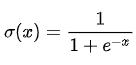

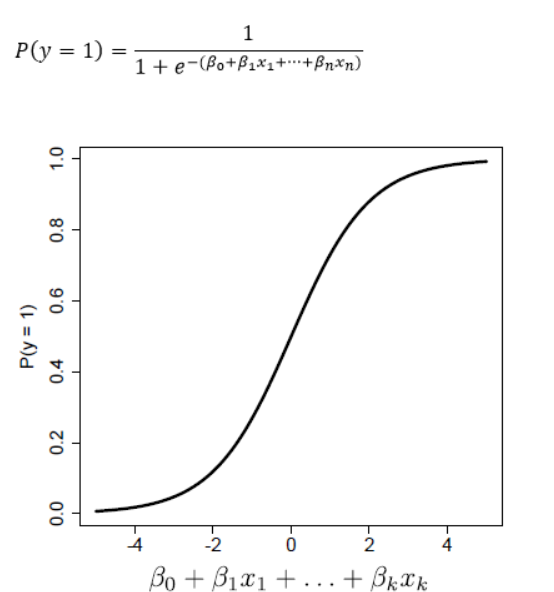

In [89]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)

LogisticRegression()

In [90]:
y_test_predict = logistic_model.predict(x_test)
y_test_predict

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

In [91]:
y_test_predict_proba = logistic_model.predict_proba(x_test)
y_test_predict_proba[:10]

array([[0.56071855, 0.43928145],
       [0.62782898, 0.37217102],
       [0.67085122, 0.32914878],
       [0.71031035, 0.28968965],
       [0.61826214, 0.38173786],
       [0.72684224, 0.27315776],
       [0.42082223, 0.57917777],
       [0.61077944, 0.38922056],
       [0.61661352, 0.38338648],
       [0.53781776, 0.46218224]])

In [92]:
# Вероятности принадлежности к 0 классу
[round(x, 4) for x in y_test_predict_proba[:10,0]]

[0.5607,
 0.6278,
 0.6709,
 0.7103,
 0.6183,
 0.7268,
 0.4208,
 0.6108,
 0.6166,
 0.5378]

In [93]:
# Вероятности принадлежности к 1 классу
[round(x, 4) for x in y_test_predict_proba[:10,1]]

[0.4393,
 0.3722,
 0.3291,
 0.2897,
 0.3817,
 0.2732,
 0.5792,
 0.3892,
 0.3834,
 0.4622]

In [94]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [95]:
accuracy_score(y_test, y_test_predict)

0.48484848484848486

In [96]:
print_accuracy_score_for_classes(y_test, y_test_predict)

Метка 	 Accuracy
0 	 0.8064516129032258
1 	 0.2


In [97]:
y_test_predict = logistic_model.predict(x_test)

In [98]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [99]:
print_class_proportions(y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 31 	 	 46.97%
1 	 35 	 	 53.03%


### **Метод опорных векторов (SVM)**

Основная идея метода — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с максимальным зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. Алгоритм работает в предположении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.

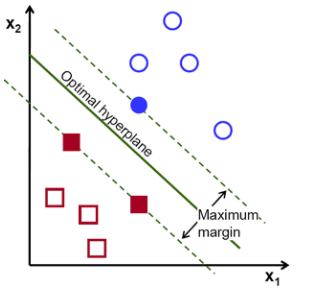

- На этапе обучения (fit) по точкам (векторам) обучающей выборки строится уравнение оптимальной разделяющей гиперплоскости. Это сложная задача, которая решается с применением методов оптимизации.
- На этапе предсказания (predict) точка тестовой выборки подставляется в полученное уравнение и определяется класс, к которому принадлежит точка.

In [100]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(data_clean2_np, target_np)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = data_clean2_np[:, 0], data_clean2_np[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=target_np, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

C:\Users\Pocht\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


MemoryError: Unable to allocate 14.1 GiB for an array with shape (687, 2756939) and data type float64

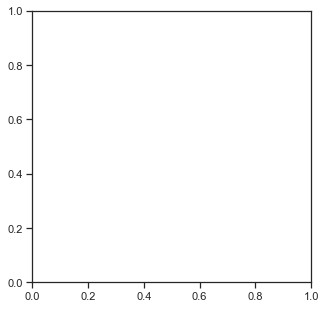

In [105]:
plot_cl(LinearSVC(C=1.0, max_iter=1000))

## **Оценка качества модели**

**Метрики качества классификации**
- Accuracy
- Матрица ошибок или Confusion Matrix
- Precision, recall и F-мера
- ROC-кривая и ROC AUC
- Кривая precision-recall
- Логистическая функция потерь - log loss

**Метрики качества регрессии**
- Mean absolute error - средняя абсолютная ошибка
- Mean squared error - средняя квадратичная ошибка, и Root mean squared error - корень из средней квадратичной ошибки
- Median absolute error
- Метрика R2 или коэффициент детерминации

Мы решаем задачу классификации, поэтому проверим соответствующие метрики

### **Accuracy**
Метрика вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов.

Accuracy - доля верно предсказанных классификатором положительных и отрицательных объектов:

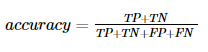

In [103]:
# 1 параметр - эталонное значение классов из исходной (тестовой) выборки
# 2 параметр - предсказанное значение классов

# 3 ближайших соседа
accuracy_score(y_test, m_predict)

NameError: name 'm_predict' is not defined

In [ ]:
# 10 ближайших соседей
accuracy_score(y_test, m2_predict)

0.5685975609756098

Так как у нас бинарная классификация, можем использовать balanced_accuracy_score

In [ ]:
# 3 ближайших соседа
balanced_accuracy_score(y_test, m_predict)

0.5000426301878571

In [ ]:
# 10 ближайших соседей
balanced_accuracy_score(y_test, m2_predict)

0.5170520751428112

Итог: для 10 соседей точность больше для выборки в целом

Вывод оценок для каждого класса (насколько мы будем предостережены от небезопасной воды, и сколько безопасной воды зря уйдет в утилизацию)

In [ ]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [ ]:
# 3 ближайших соседа
print_accuracy_score_for_classes(y_test, m_predict)

Метка 	 Accuracy
0 	 0.6997319034852547
1 	 0.3003533568904594


In [ ]:
# 10 ближайших соседей
print_accuracy_score_for_classes(y_test, m2_predict)

Метка 	 Accuracy
0 	 0.8927613941018767
1 	 0.1413427561837456


### **Матрица ошибок (Confusion Matrix)**
Количество верно и ошибочно классифицированных данных, представленное в виде матрицы

Будем использовать confusion_matrix из sklearn, которая выводит следующую таблицу

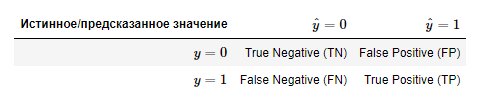

- True Positive (TP) - количество верно предсказанных значений 1 класса
- False Positive (FP) - количество неверно предсказанных значений 1 класса (предсказана 1 но истинное значение 0) - ошибка I рода, «ложное срабатывание».
- True Negative (TN) - количество верно предсказанных значений 0 класса
- False Negative (FN) - количество неверно предсказанных значений 0 класса (предсказан 0 но истинное значение 1) - ошибка II рода, «пропуск цели, пропуск события».

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, m_predict).ravel()
tn, fp, fn, tp

(261, 112, 198, 85)

Постороим графики plot для наглядности

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


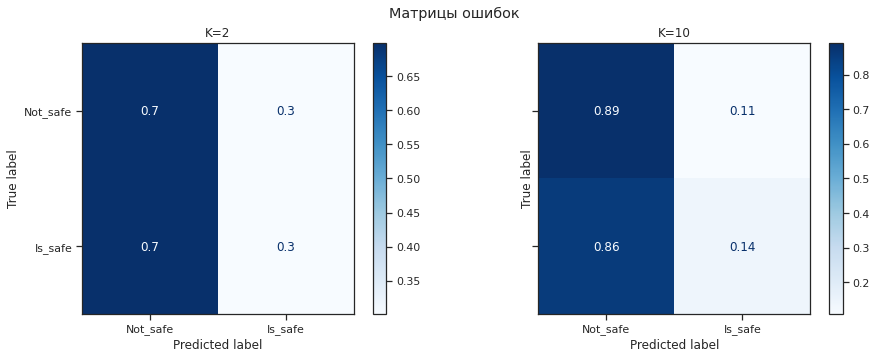

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
labels = ['Not_safe', 'Is_safe']

plot_confusion_matrix(model, x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_test,
                      display_labels=labels, cmap=plt.cm.Blues, normalize='true', ax=ax[0])

plot_confusion_matrix(model2, x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_test,
                      display_labels=labels, cmap=plt.cm.Blues, normalize='true', ax=ax[1])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K=2')
ax[1].title.set_text('K=10')

Модель 10 соседей лучше предсказывает значения для небезопасной воды, модель 2 соседей для безопасной. В данном случае модель для 10 соседей использовать лучше. 

### **Precision, recall и F-мера**

**Precision** \
Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

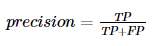

In [ ]:
# По умолчанию метрики считаются для 1 класса бинарной классификации
# Для 3 и 10 ближайших соседей
precision_score(y_test, m_predict), precision_score(y_test, m2_predict)

(0.43147208121827413, 0.5)

У функции precision_score есть параметр average, который указывает как считать TP, TN, FP, FN

In [ ]:
# Параметры TP, TN, FP, FN считаются как сумма по всем классам
precision_score(y_test, m_predict, average='micro'), precision_score(y_test, m2_predict, average='micro')

(0.5274390243902439, 0.5685975609756098)

In [ ]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется среднее значение, дисбаланс классов не учитывается.
precision_score(y_test, m_predict, average='macro'), precision_score(y_test, m2_predict, average='macro')

(0.5000497660993332, 0.5390625)

In [ ]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется средневзвешенное значение, дисбаланс классов учитывается 
# в виде веса классов (вес - количество истинных значений каждого класса).
precision_score(y_test, m_predict, average='weighted'), precision_score(y_test, m2_predict, average='weighted')

(0.5094582899397223, 0.5444216844512195)

**Recall (полнота)** \
показывает, какую долю объектов, реально относящихся к положительному классу, мы предсказали верно

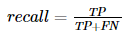

In [ ]:
# Для 3 и 10 ближайших соседей
recall_score(y_test, m_predict), recall_score(y_test, m2_predict)

(0.3003533568904594, 0.1413427561837456)

**F-мера** \
Для того, чтобы объединить precision и recall в единую метрику используется Fβ-мера, которая вычисляется как среднее гармоническое от precision и recall

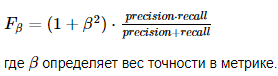

Используются функции f1_score (β=1) и fbeta_score (также есть параметр average)

In [ ]:
# Для 3 и 10 ближайших соседей
fbeta_score(y_test, m_predict, average='macro', beta=0.5), fbeta_score(y_test, m2_predict, average='macro', beta=0.5)

(0.4937952244425762, 0.4768199223035613)

**Удобный вывод метрик** \
Функция classification_report позволяет выводить значения точности, полноты и F-меры для всех классов выборки.

In [ ]:
# Для 3 и 10 ближайших соседей
classification_report(y_test, m_predict, target_names=['Not_safe', 'Is_safe'], output_dict=True), \
 classification_report(y_test, m2_predict, target_names=['Not_safe', 'Is_safe'], output_dict=True)

({'Is_safe': {'f1-score': 0.3541666666666667,
   'precision': 0.43147208121827413,
   'recall': 0.3003533568904594,
   'support': 283},
  'Not_safe': {'f1-score': 0.6274038461538461,
   'precision': 0.5686274509803921,
   'recall': 0.6997319034852547,
   'support': 373},
  'accuracy': 0.5274390243902439,
  'macro avg': {'f1-score': 0.4907852564102564,
   'precision': 0.5000497660993332,
   'recall': 0.5000426301878571,
   'support': 656},
  'weighted avg': {'f1-score': 0.5095286604909318,
   'precision': 0.5094582899397223,
   'recall': 0.5274390243902439,
   'support': 656}},
 {'Is_safe': {'f1-score': 0.22038567493112948,
   'precision': 0.5,
   'recall': 0.1413427561837456,
   'support': 283},
  'Not_safe': {'f1-score': 0.701791359325606,
   'precision': 0.578125,
   'recall': 0.8927613941018767,
   'support': 373},
  'accuracy': 0.5685975609756098,
  'macro avg': {'f1-score': 0.46108851712836774,
   'precision': 0.5390625,
   'recall': 0.5170520751428112,
   'support': 656},
  'weig

### **ROC-кривая(кривая ошибок) и ROC AUC**
ROC-кривая - график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (TPR), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (FPR) при варьировании порога решающего правила.

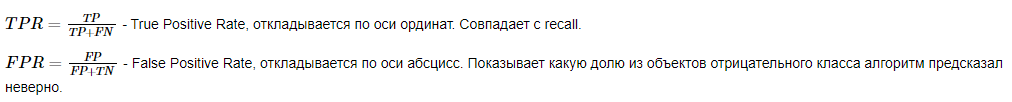

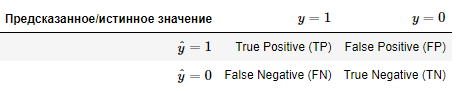

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора

In [ ]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

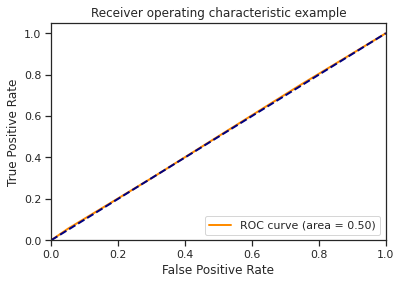

In [ ]:
# для 3 соседей
m_proba = model.predict_proba(x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])
true_m_proba = m_proba[:,1]
roc_curve_k10_res = roc_curve(y_test, true_m_proba, pos_label=1)
draw_roc_curve(y_test, true_m_proba, pos_label=1, average='micro')

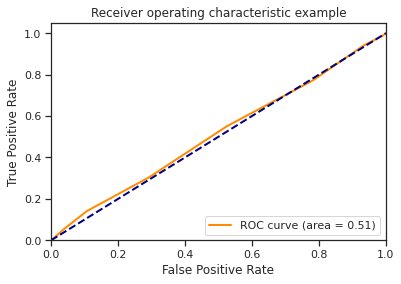

In [ ]:
# для 10 соседей
m2_proba = model2.predict_proba(x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])
true_m2_proba = m2_proba[:,1]
roc_curve_k10_res = roc_curve(y_test, true_m2_proba, pos_label=1)
draw_roc_curve(y_test, true_m2_proba, pos_label=1, average='micro')

### **Кривая precision-recall**
Аналогично ROC-кривой также можно строить кривую precision-recall. Обычно ее используют в случае сильного дисбаланса классов. У нас классов всего 2, поэтому использовать ее не будем

## **Метод опорных векторов**

Метод очень точный, но долго обучается. Он был изобретен в СССР профессорами  Владимиром Вапником и Алексеем Червоненкисом.

Здесь используется метод оптимизации, чаще всего градиентный спуск.

Основная идея метода.
Точки нашей обучающей выборки представляются как вектора. То есть это метод опорных точек.
Изначально здесь ставится задача бинарной классификации. Но также он расширен для решения задачи регрессии.

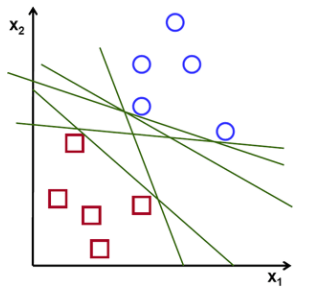

У нас есть оптимальная и вспомогательные плоскости, которые разделяют точки. Нам нужно найти оптимальный вектор, для которого расстояние между ним и точками будет максимальное.

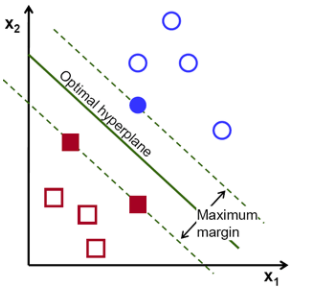

Ширина полосы должны быть максимальная.

Основная идея метода (из Википедии) — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с максимальным зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. Алгоритм работает в предположении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.

**Термины**
- Вектор - точка в многомерном пространстве. Соответствует одному объекту обучающей или тестовой выборки. В рассматриваемом примере это двухмерное пространство (x1,x2)
- Опорный вектор - такая точка, которая участвует в построении оптимальной гиперплоскости.
- Гиперплоскость - подпространство с размерностью, на единицу меньшей, чем объемлющее пространство. Для двухмерного пространства (плоскости) частным случаем гиперплоскости является прямая, для трехмерного пространства гиперплоскостью является плоскость.
- Разделяющая гиперплоскость - гиперплоскость, которая каким-то образом разделяет вектора (точки в многомерном пространстве), принадлежащие различным классам. Возможно, разделяет с ошибками.
- Оптимальная (разделяющая) гиперплоскость - такая разделяющая гиперплоскость, которая обеспечивает максимальный зазор (margin) между векторами (точками) различных классов.

- На этапе обучения (fit) по точкам (векторам) обучающей выборки строится уравнение оптимальной разделяющей гиперплоскости. Это сложная задача, которая решается с применением методов оптимизации.
- На этапе предсказания (predict) точка тестовой выборки подставляется в полученное уравнение и определяется класс, к которому принадлежит точка.

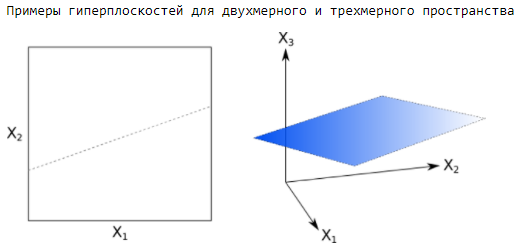

In [ ]:
from sklearn.datasets import make_blobs, make_circles

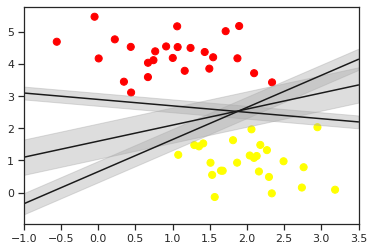

In [ ]:
# Пример кода из книги Дж. Вандер Пласа
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

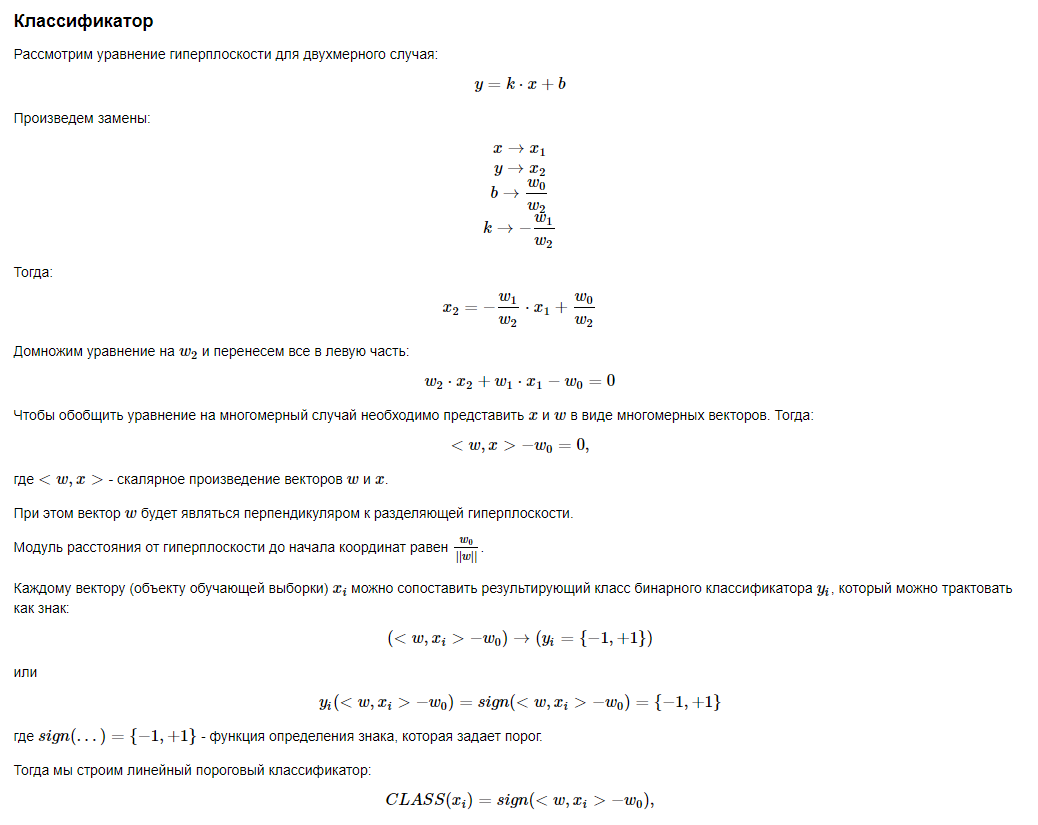

После обучения, мы проверяем точку - и мы можем понять, находится она над или под гиперплоскостью, уравнение которой мы нашли при обучении.

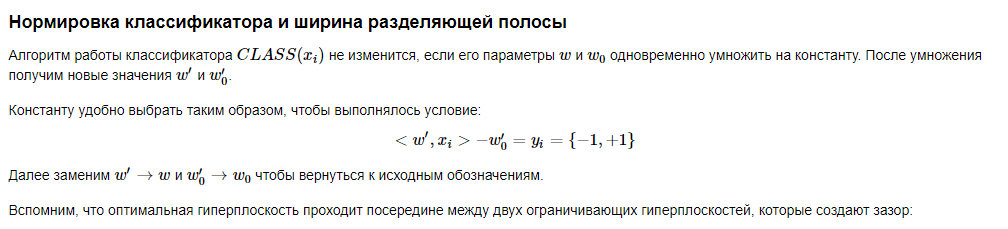

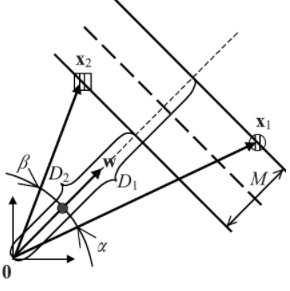

Из точки 0 мы проводим вектора и рассматриваем расстояние до точек х1, х2.
Гиперплоскость должна проходить посередине, между метками. 

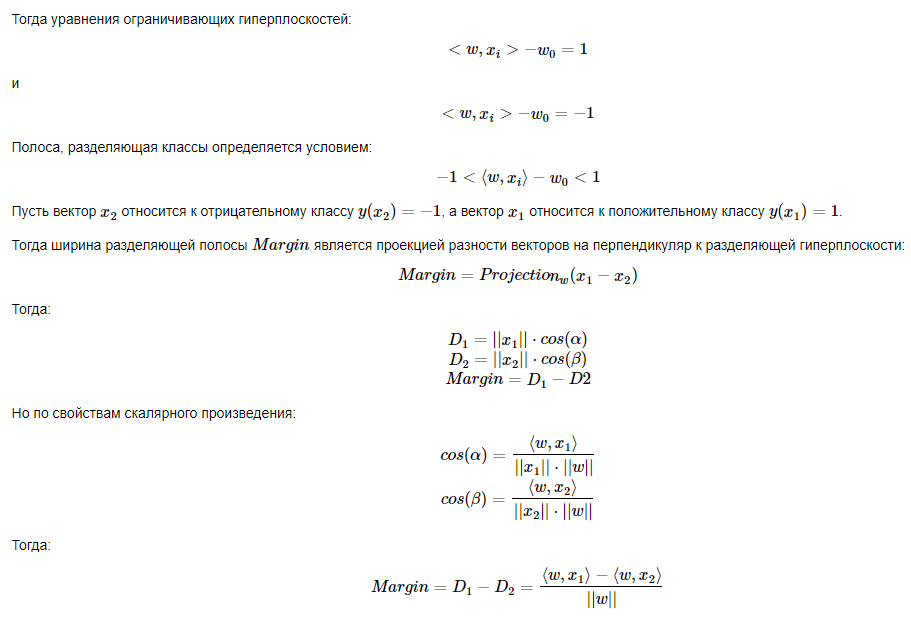

хi - длины векторов

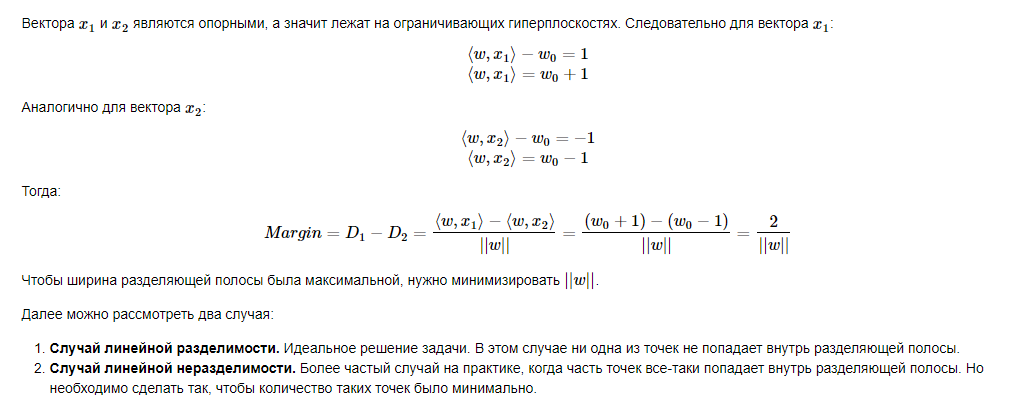

Нам нужно максимизировать ширину разделяющей полосы, поэтому margin равен именно 2/||w||

Нам нужно подобрать такие коэфициенты при х, чтобы w было минимальной.

Дальше рассмотрим линейную разделимость и неразделимость

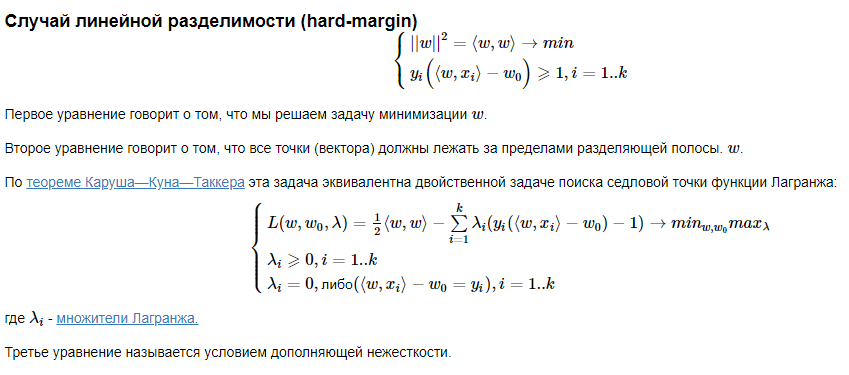

Нам нужно минизировать w. Будем минимизировать w^2, задача та же. Раз минизируем квадрат, то можем рассмотреть квадрат длины как скалярное произведение (на картинке выше) <w,w>
условие >= 1, т.к. точки должны лежать на разделяющей полосе или вне её.
Дальше нам нужно минизировать функцию по w, максимизировать по лямбда, для этого воспользуемся теоремой для оптимизации Каруша-Куна-Таккера.

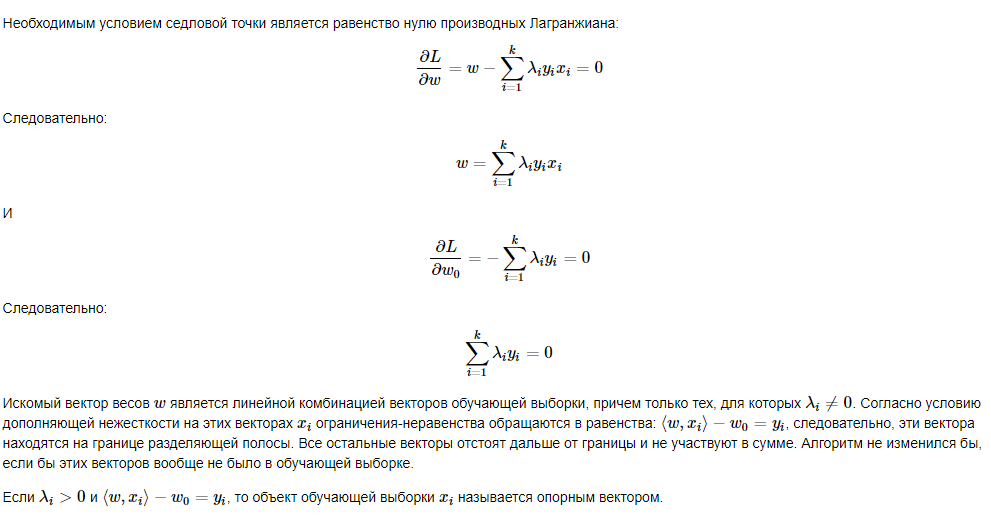

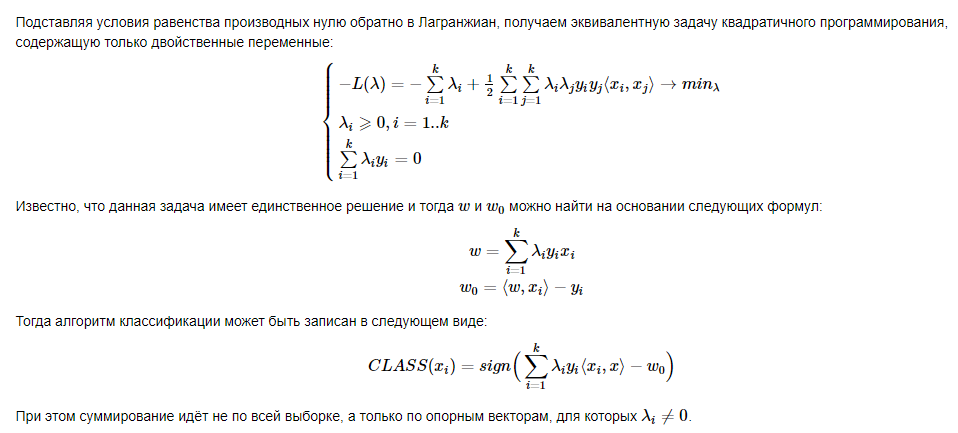

Суммирование идет не по всей выборке, а только по опорным векторам.

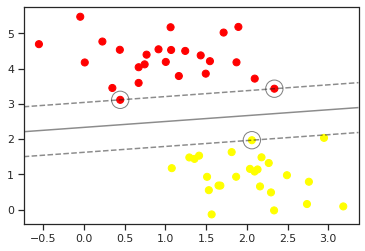

In [ ]:
# Пример кода из книги Дж. Вандер Пласа
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, color='none', edgecolor='grey');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
model = SVC(kernel='linear', C=1E10)
model.fit(X, y) 

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model) 

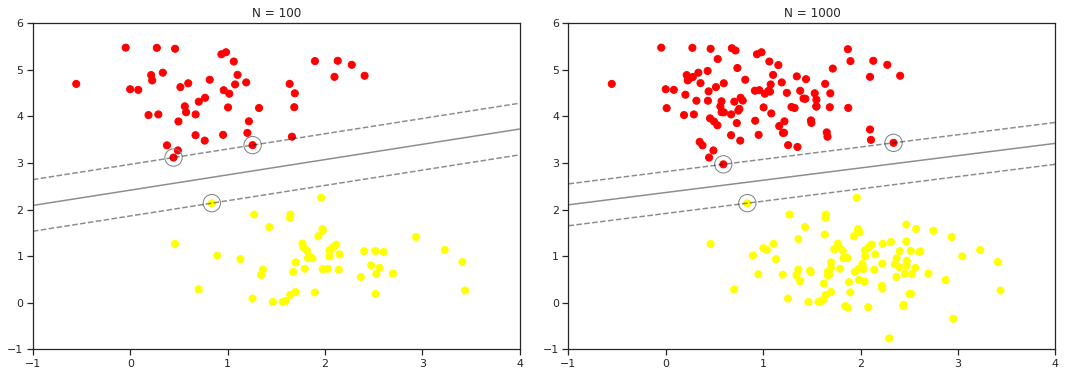

In [ ]:
# Пример кода из книги Дж. Вандер Пласа
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [100, 1000]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))    


Если добавляем ещё точек (до границы) в нашу обучающую выборку, то на модель это никак влияет, т.к. этот метод ориентируется только на точки, которые находятся на границе. Но минус в том, что метод будет очень чувствителен к выбросам, т.к. он сильно реагирует на точки, которые могут быть опорными векторами.

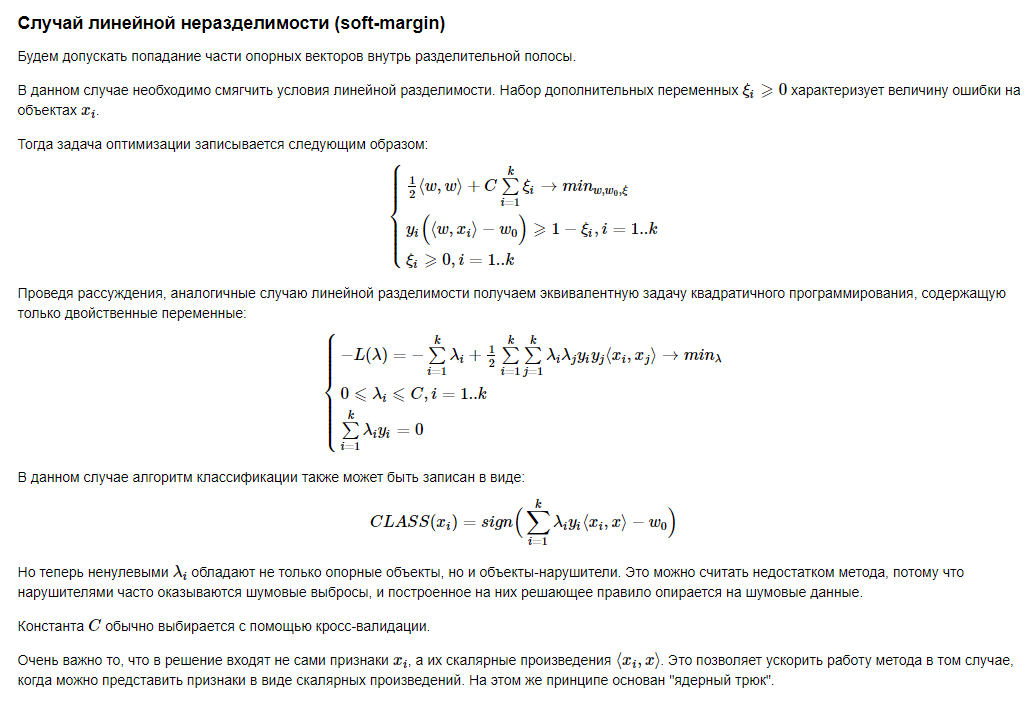

Здесь ограничения уже делаются на коэфициенты лямбда.

Линейная неразделимость применяется, чтобы смягчить чувствительность к выбросам

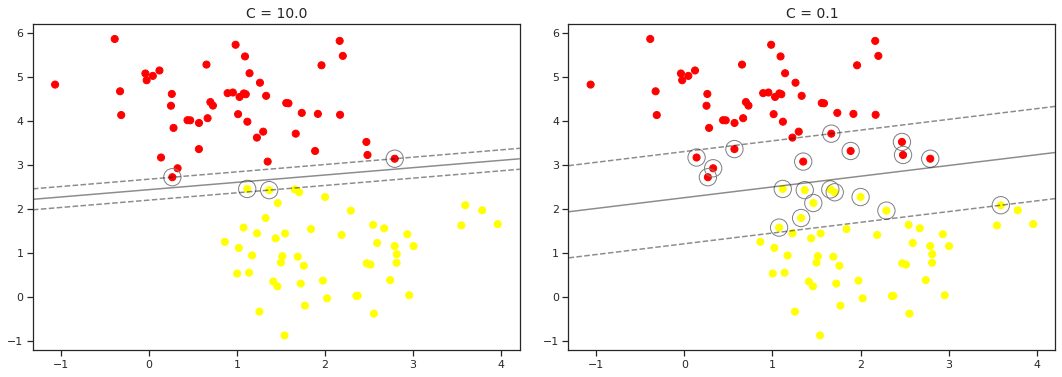

In [ ]:
# Пример кода из книги Дж. Вандер Пласа
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Величина С влияет на границу разделяемой полосы. Чем меньше С, тем шире разделяющая полоса. Опорные вектора теперь и точки, которые внутри разделяющей полосы. Но мы стремимся к тому, чтобы точек внутри разделяющей полосы было как можно меньше.

Дальше рассмотрим ядерный трюк. Переводим признаки в пространство более высокой размерности, там решаем линейную задачу, а когда возвращаемся обратно, то наша гиперплоскость уже становится нелинейной. Чаще всего используется радиально базисное ядро.

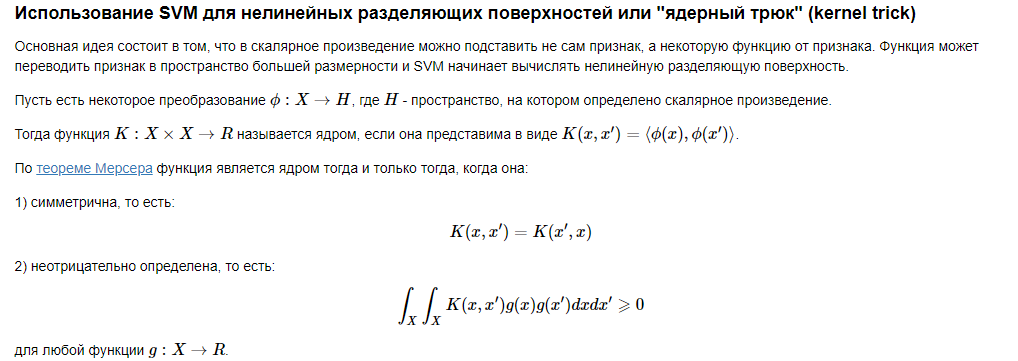

В скалярное произведение подставляем не сам признак а функцию признака.

Ядро - функция, которая симметрична и неотрицательно определена

Функции, которые удовлетворяют теореме Мерсера:

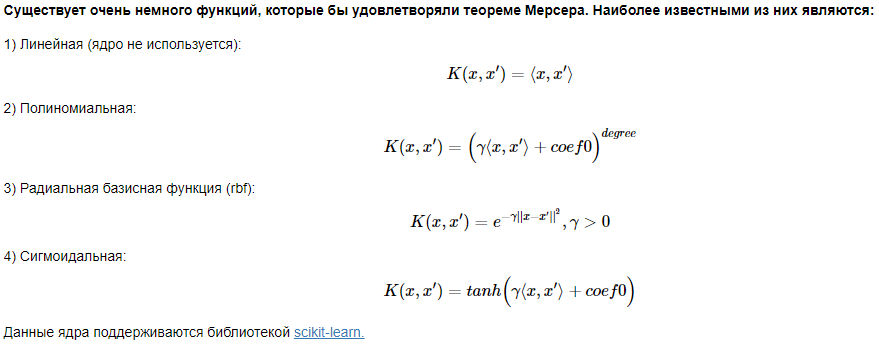

Обычный способ:

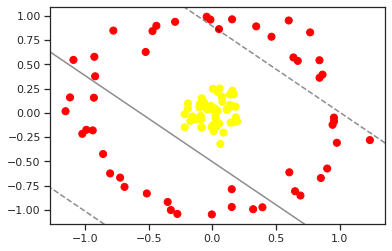

In [ ]:
# Пример кода из книги Дж. Вандер Пласа
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Ядерный трюк. Мы смогли перейти от нелийной модели к линейной.

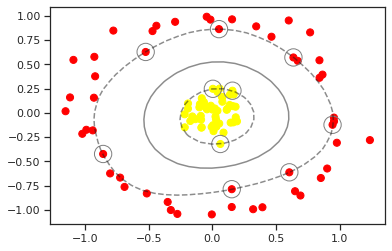

In [ ]:
# Пример кода из книги Дж. Вандер Пласа
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

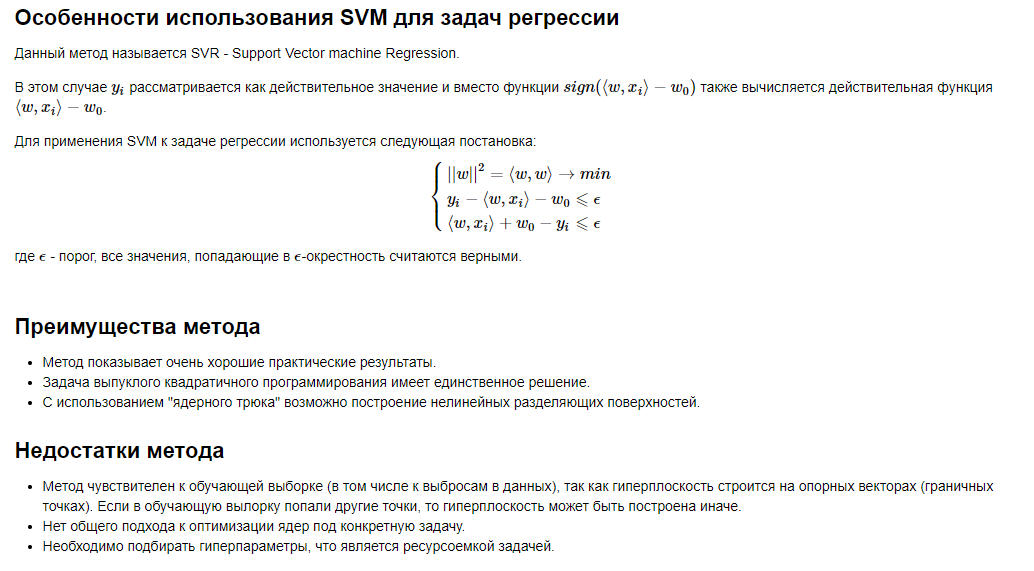